# Processing Koike-Yusa 2014
- Processing genomewide screen from [Koike-Yusa](https://www.nature.com/articles/nbt.2800)
- Library design: To avoid off-target cleavages, only gRNAs that matched stringent conditions were chosen:
from position 8, the 5′-N14GG-3′ of each gRNA only had a single match to the mouse genome.
A total of 325,638 sites was identified... Filtering was performed as follows: First, sites with more than
1 perfect hit in any of the Ensembl exons were removed. Second, off-target sites of each candidate gRNA were examined
with the following two options (i) N12NGG without any mismatches and (ii) N20NGG with up to three mismatches.
Third, gRNAs that are positioned at least 100 bp away from the translation initiation site and in the
first half of coding sequences were collected.
Finally, up to 5 gRNAs were chosen for each gene, prioritizing gRNAs with fewer predicted off-target sites.
- sgRNAs are 19mers

### Data Filters
1. pdna or etp > mean pdna -3 std
2. sgRNAs targetting essential genes
3. Match bin 1, tier 1 score of 0

In [6]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
from poola import core as pool

In [7]:
annotations = pd.read_csv('../data/raw/Koike-Yusa2014_library_annotations.csv')
reads = pd.read_csv('../data/raw/Koike-Yusa2014_reads.csv')
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/mouse/mouse_essentials.txt',
                                names=['gene'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/mouse/mouse_non-essentials.txt',
                                    names=['gene'])

In [8]:
clean_reads = (reads.dropna()
               .rename({'Unnamed: 0': 'id', 
                        'ESC1 (normalized)': 'ESC_1', 
                        'ESC2 (normalized)': 'ESC_2'}, axis=1)
               .copy())
clean_reads[['transcript', 'Gene', 'exon', 'exon_#', 'target']] = clean_reads['id'].str.split('_', expand=True)
clean_reads[['chr_#', 'range', 'Strand']] = clean_reads.target.str.split(':', expand=True)
clean_reads['End'] = (clean_reads['range'].str.split('-', expand=True)[1]
                      .astype('int'))
clean_reads['Chr'] = 'chr' + clean_reads['chr_#']
clean_reads = clean_reads[['id', 'Lentiviral Plasmid', 'ESC_1', 'ESC_2', 'Gene', 'Chr', 'End', 'Strand']]

In [9]:
lognorms = pool.lognorm_columns(reads_df=clean_reads, columns=['Lentiviral Plasmid', 'ESC_1', 'ESC_2'])
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['Lentiviral Plasmid'])
print('pDNA Filtered: ' + str(filtered_lognorms.shape[0] - lognorms.shape[0]))

pDNA Filtered: 0


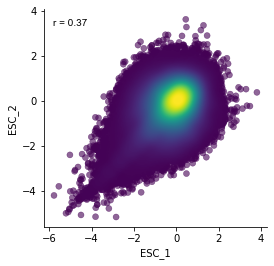

In [10]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='Lentiviral Plasmid', 
                             target_cols=['ESC_1', 'ESC_2'])
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(lfc_df, x = 'ESC_1', y = 'ESC_2')
gpplot.add_correlation(lfc_df, x = 'ESC_1', y = 'ESC_2')
sns.despine()

Note that Sept and March genes are missing annotations

In [11]:
annotated_lfcs = lfc_df.merge(annotations, how='inner', on=['Gene', 'Chr', 'End', 'Strand'])
print('Missing annotations: ' + str(lfc_df.shape[0] - annotated_lfcs.shape[0])) # sept and march genes are missing

Missing annotations: 113


We see that the target site sequence is a 20mer which matches the gRNA sequence from the first position onwards

In [12]:
print((annotated_lfcs['Target site sequence'].str[1:] != annotated_lfcs['gRNA sequence']).sum())

0


In [13]:
avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=annotated_lfcs, guide_col='Target site sequence', 
                                                   condition_indices=[0], lfc_cols=['ESC_1', 'ESC_2'], sep='_')

In [14]:
sg_list = list(annotated_lfcs['Target site sequence'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_10090_GRCm38_SpyoCas9_CRISPRko_Ensembl_20200406.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [29]:
lfcs_designs = pool.annotate_guide_lfcs(avg_replicate_lfc_df.rename({'Target site sequence': 'sgRNA Sequence'}, axis=1),
                                        design_df, 'Target Gene Symbol', merge_on='sgRNA Sequence')
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.gene,
                                fp_genes=nonessential_genes.gene, gene_col='Target Gene Symbol',
                                condition_col='condition', score_col='avg_lfc')
roc_aucs

,condition,ROC-AUC
0,ESC,0.763577


In [43]:
ess_lfcs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(essential_genes.gene)]
ot_filtered_sgs = ess_lfcs[(ess_lfcs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
print('Off target filtered: ' + str(ess_lfcs.shape[0] - ot_filtered_sgs.shape[0]))
filtered_sgs = ot_filtered_sgs[ot_filtered_sgs.groupby('Target Gene Symbol')
                               ['sgRNA Sequence']
                               .transform(lambda x: x.nunique()) > 1].copy()
print('sgRNA per gene filter: ' + str(ot_filtered_sgs.shape[0] - filtered_sgs.shape[0]))
filtered_sgs['neg_gene_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol'])
                                   .avg_lfc
                                   .transform(lambda x: -(x - x.mean())/x.std()))
filtered_sgs = filtered_sgs[['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                             'Target Cut %', 'On-Target Efficacy Score', 'neg_gene_zscore']].copy()

Off target filtered: 124
sgRNA per gene filter: 17


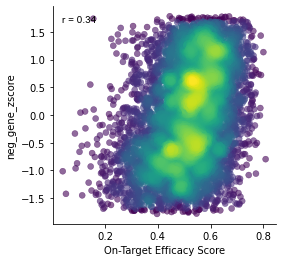

In [44]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(filtered_sgs, x='On-Target Efficacy Score', y='neg_gene_zscore')
gpplot.add_correlation(filtered_sgs, x='On-Target Efficacy Score', y='neg_gene_zscore', method='spearman')
sns.despine()

## Output

In [45]:
output_df = filtered_sgs.drop('On-Target Efficacy Score', axis=1)
output_df

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,neg_gene_zscore
4,AAAAAACTTGTCTACGGAAA,CCAGAAAAAACTTGTCTACGGAAAAGGGAT,Ythdc1,18.5,0.972454
26,AAAAACAGAACACCGAACAT,CCTTAAAAACAGAACACCGAACATCGGCTG,Ncapg2,38.1,1.210263
34,AAAAACGGTCTCAAGCCAAT,GATGAAAAACGGTCTCAAGCCAATGGGGCA,Parn,24.5,-0.705264
37,AAAAACTTACGCAACTCCAT,GGACAAAAACTTACGCAACTCCATGGGGAG,Usp7,18.3,-1.025135
38,AAAAACTTCTCGTTCCAGAG,GGTTAAAAACTTCTCGTTCCAGAGGGGTTC,Utp14b,26.4,-0.048350
...,...,...,...,...,...
87805,TTTTTGCCACTCGTGAAATC,AACATTTTTGCCACTCGTGAAATCTGGTCT,Etf1,10.2,-0.793640
87818,TTTTTTAACGGTCCTGGTTT,TGTTTTTTTTAACGGTCCTGGTTTGGGTCC,Ckap5,26.5,-1.182229
87832,TTTTTTTAACCCAGGTTGAT,TTTTTTTTTTTAACCCAGGTTGATAGGACC,Rps21,46.4,-1.052139
87834,TTTTTTTGGAAAGTCACGTT,AAGATTTTTTTGGAAAGTCACGTTCGGCAT,Cul2,9.1,-1.373374


In [46]:
output_df.to_csv('../data/processed/Koike-Yusa2014_activity.csv', index=False)